# Определение стоимости автомобилей

**Проект разработки приложения для определения рыночной стоимости автомобилей с пробегом требует построения модели на основе<br> технических характеристики, комплектации и цены автомобилей**

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План проекта

1. Загрузим и изучим данные
2. Преодработаем данные
   - Избавимся от неинформативных признаков
   - Проверим на пропуски, строки дубликаты и аномалии
   - Проверим корреляцию признаков
   - Создадим пайплайн, включающий кодирование категориальных признаков, масштабирование числовых и обучение модели
3. Подготовим выборки
4. Обучим несколько разных моделей, для каждой подберем оптимальные гиперпараметры
5. Сравним модели по времени обучения, предсказания и качеству
6. Опираясь на критерии заказчика, выберем лучшую модель и проверим ее на тестовой выборке

**Качество модели будем оценивать метрикой RMSE, минимальный удовлетворяющий результат - 2500**

## Загрузка данных

In [1]:
!pip -q install -U scikit-learn
!pip -q install imblearn
!pip install -q fast_ml
!pip install -q networkx
!pip -q install missingno
!pip -q install category_encoders
!pip -q install catboost
!pip -q install lightgbm
!pip -q install optuna

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import networkx as nx
import copy
import missingno as msno
import re 
import lightgbm as lgb
import catboost as cb
import optuna
import time 

from category_encoders import TargetEncoder
from imblearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor

In [3]:
def gaps(data):
    col_with_misses = []
    for col in data.columns:
            gaps = data[col].isna().sum()
            if gaps > 0:
                print(f'Количество пропусков в столбце \
{col} ({data[col].dtypes}): {gaps}, {(gaps / len(data)):.2%} от всех данных')         
                col_with_misses.append(col)
    return col_with_misses

In [4]:
def get_dict():
    '''
    Функция возвращает словарь с образцами данных для обучения и тестирования модели.
    '''
    samples = {
        'features_train': X_train,
        'features_test': X_test,
        'features_valid': X_val,
        'target_train': y_train,
        'target_valid': y_val,
        'target_test': y_test
    }
    return samples

In [5]:
def get_size(samples):
    '''
    Функция выводит размеры выборок
    '''
    for name, sample in samples.items():
        print(f'- Размер выборки {name}: {sample.shape}')

## Изучение данных

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Избавимся от неинформативных столбцов

Для прогнозирования рыночной стоимости автомобиля неинформативны следующие признаки:
  - Дата скачивания анкеты из базы
  - Месяц регистрации автомобиля
  - Дата создания анкеты
  - Количество фотографий автомобиля
  - Почтовый индекс владельца анкеты
  - Дата последней активности пользователя
  

Прежде чем навсегда отбрасывать эти признаки, воспользуемся полным набором столбцов для поиска строк дубликатов

In [8]:
df.duplicated().sum()

4

Проверим на дубликаты без учета столбцов с
- Датой создания аккаунта
- Временем последнего визита
- Количеством фотографий
- Почтовым индексом. Повторную анкету владелец мог разместить после переезда, маловероятно что у двух пользователей все признаки за исключением почтового индекса будут идентичны

In [9]:
df.drop(['LastSeen', 'DateCreated', 'NumberOfPictures'], axis=1).duplicated().sum()

19

In [10]:
df.drop(['LastSeen', 'DateCreated', 'PostalCode', 'NumberOfPictures'], axis=1).duplicated().sum()

25

In [11]:
df = df.drop(['LastSeen', 'DateCreated', 'PostalCode', 'NumberOfPictures'], axis=1).drop_duplicates()

Теперь отбросим остальные неинформативные признаки

In [12]:
df.drop(df.columns[[0, 8]], axis=1, inplace=True)

In [13]:
df.head(0)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


### Изучим общую информацию

In [14]:
df.shape

(354344, 10)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354344 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354344 non-null  int64 
 1   VehicleType       316854 non-null  object
 2   RegistrationYear  354344 non-null  int64 
 3   Gearbox           334511 non-null  object
 4   Power             354344 non-null  int64 
 5   Model             334639 non-null  object
 6   Kilometer         354344 non-null  int64 
 7   FuelType          321449 non-null  object
 8   Brand             354344 non-null  object
 9   Repaired          283190 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [16]:
df.dtypes

Price                int64
VehicleType         object
RegistrationYear     int64
Gearbox             object
Power                int64
Model               object
Kilometer            int64
FuelType            object
Brand               object
Repaired            object
dtype: object

In [17]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,354344.0,NaN,NaN,NaN,4416.561477,4514.167328,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316854,8,sedan,91452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354344.0,NaN,NaN,NaN,2004.234563,90.231117,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334511,2,manual,268233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354344.0,NaN,NaN,NaN,110.091352,189.855996,0.0,69.0,105.0,143.0,20000.0
Model,334639,250,golf,29227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354344.0,NaN,NaN,NaN,128212.330391,37904.408738,5000.0,125000.0,150000.0,150000.0,150000.0
FuelType,321449,7,petrol,216335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,354344,40,volkswagen,77006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Repaired,283190,2,no,247137,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [19]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

### Проверим на пропуски

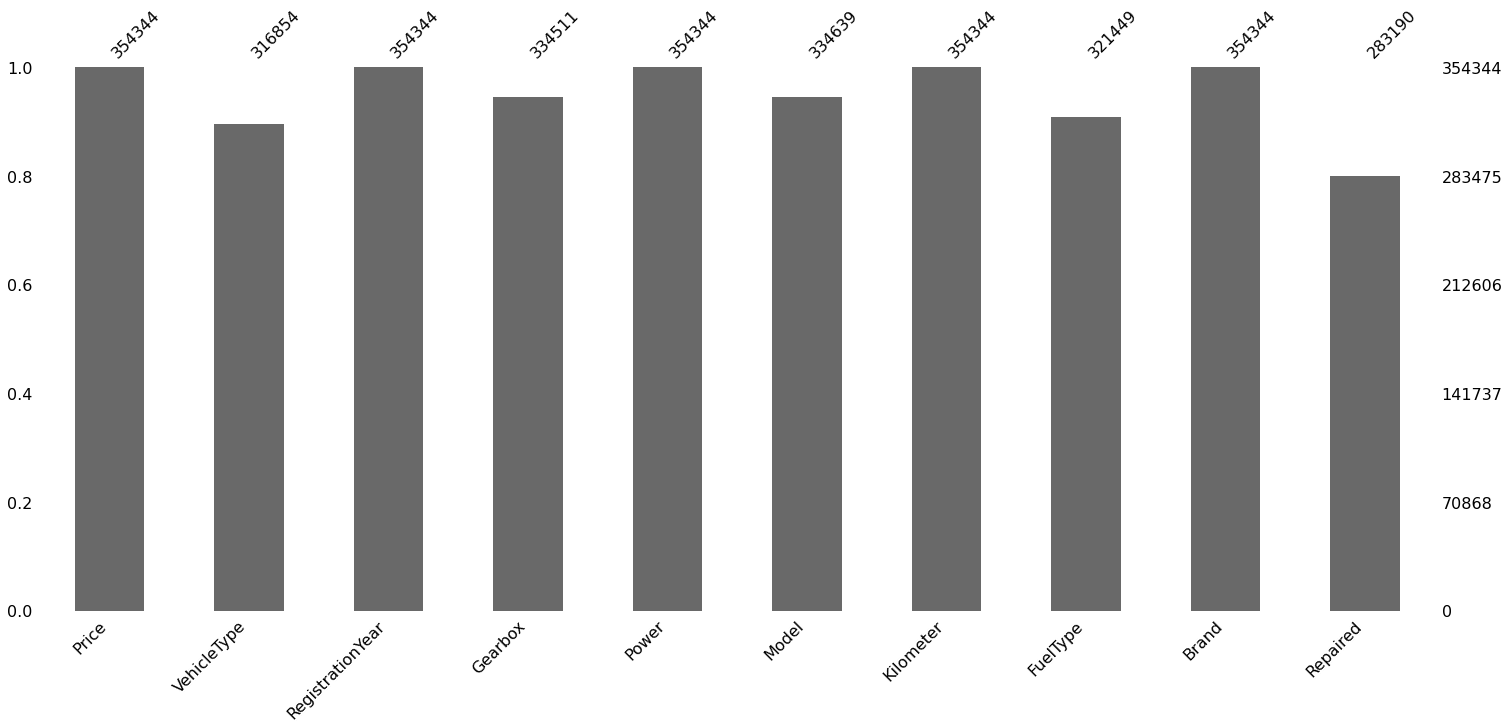

In [20]:
msno.bar(df);

In [21]:
gaps(df);

Количество пропусков в столбце VehicleType (object): 37490, 10.58% от всех данных
Количество пропусков в столбце Gearbox (object): 19833, 5.60% от всех данных
Количество пропусков в столбце Model (object): 19705, 5.56% от всех данных
Количество пропусков в столбце FuelType (object): 32895, 9.28% от всех данных
Количество пропусков в столбце Repaired (object): 71154, 20.08% от всех данных


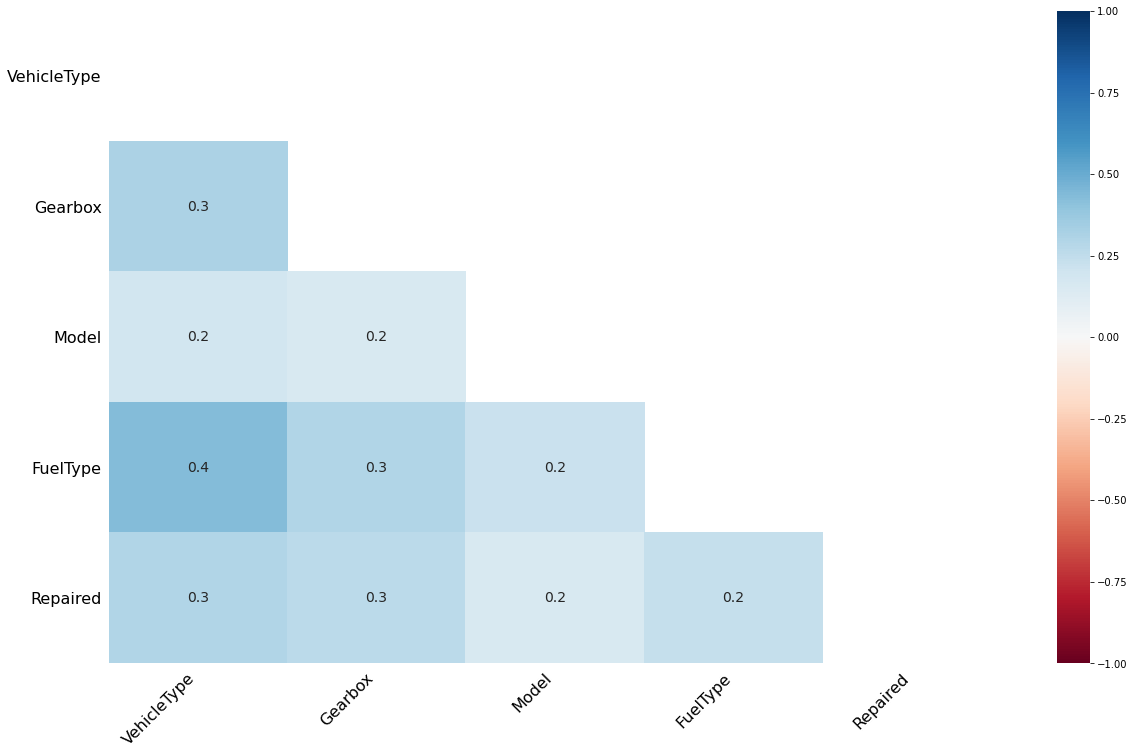

In [22]:
msno.heatmap(df);

### Промежуточный вывод

- В нашем распоряжении датафрейм, содержащий 354369 строк и 16 признаков(10 после отбрасывания неинформативных)
- Названия столбцов имеют неккоректный формат
- Имеются пропуски в 5 столбцах, от 5 до 20 % от всех строк 
  - Пропуски в разных столбцах имеют минимальную корреляцию
  - Пропуски имеются только в категориальных признаках
- Наличие и названия марки и названия модели выглядит избыточным.
- Явно видны выборсы в данных
- Необходимо проверить корреляцию для числовых признаков

## Предобработка данных

### Изменим названия столбцов для удобства

In [23]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

### Изучим корреляцию числовых признаков

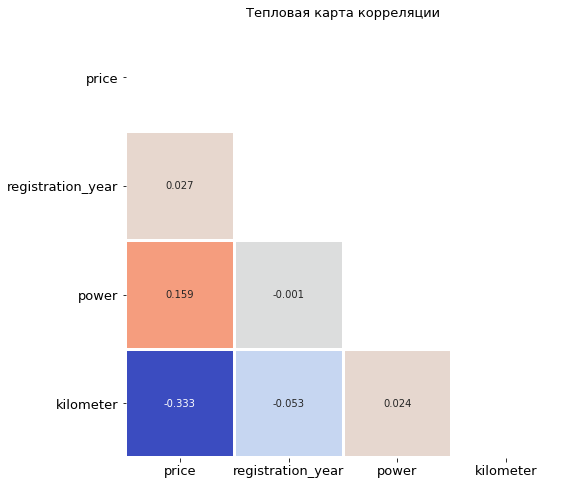

In [24]:
mask = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.heatmap(df.corr(),
                 annot=True, fmt='.3f', linewidths=2, mask=mask, square=True, cmap='coolwarm', cbar=False, center=0)
plt.title('Тепловая карта корреляции', size=13)
plt.xticks(size=13)
plt.yticks(rotation=0, size=13)
plt.show();

Корреляция у числовых признаков либо незначительная, либо ее совсем нет, мультиколлинеарность не грозит

###  Изучим данные

Напишем функции для построения графиков

In [25]:
def plot_hist(df, col, bins):
    
    sns.set(style='whitegrid')
    sns.set_palette('cool')
    sns.displot(data=df, x=col, color=sns.color_palette()[1], bins=bins, kde=True, height=6, aspect=1.5)
    plt.ylabel('Количество')

In [26]:
def plot_bar(df, col, orientation='vertical'):
    
    plt.figure(figsize=(15, 8))
    sns.set(style='whitegrid')
    if orientation == 'vertical':
        sns.countplot(x=col, data=df, palette='cool')
        plt.ylabel('Количество')
    else:
        sns.countplot(y=col, data=df, palette='cool')
        plt.xlabel('Количество')

In [27]:
def plot_boxplot(df):
    
    plt.figure(figsize=(12, 5))
    sns.set(style='whitegrid')
    sns.set_palette('cool')
    sns.boxplot(x=df)

In [28]:
def plot_line(df, col, count=True):
    
    plt.figure(figsize=(12, 6))
    sns.set(style='whitegrid')
    if count == True:
        group_df = df.groupby(col)[col].count()
        plt.ylabel('Количество')
    else:
        group_df = df.groupby(col)['price'].mean()
        plt.ylabel('Цена')
    sns.lineplot(data=group_df)
    plt.xticks(np.arange(min(df[col]), max(df[col]) + 1, 1))

#### Год регистрации 

In [29]:
df['registration_year'].describe()

count    354344.000000
mean       2004.234563
std          90.231117
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

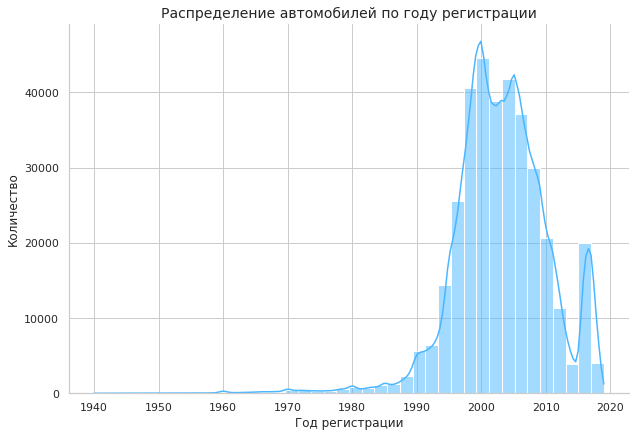

In [30]:
plot_hist(df.query('1940 <= registration_year <= 2050'), 'registration_year', 40)
plt.xlabel('Год регистрации')
plt.title('Распределение автомобилей по году регистрации', size=14);

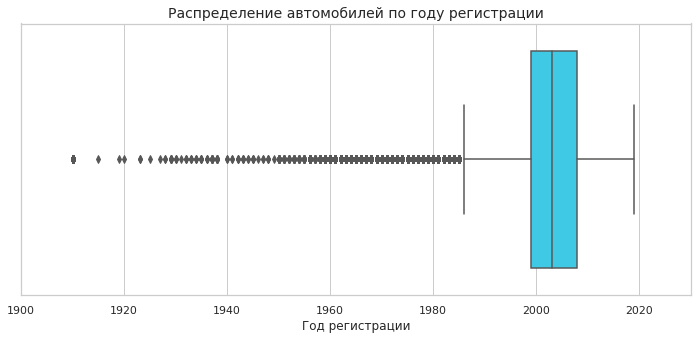

In [31]:
plot_boxplot(df['registration_year'])
plt.xlim(1900, 2030)
plt.xlabel('Год регистрации')
plt.title('Распределение автомобилей по году регистрации', size=14);

Необходимо определить какого года эта выборка и после какого года идут ошибочные данные

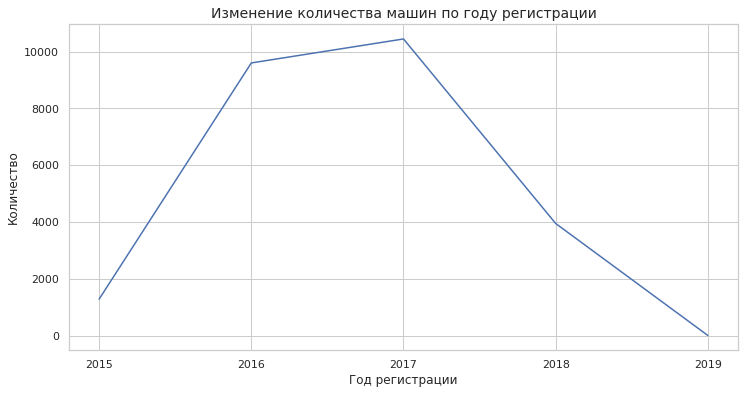

In [32]:
plot_line(df.query('2015 <= registration_year <= 2023'), 'registration_year')
plt.xlabel('Год регистрации')
plt.title('Изменение количества машин по году регистрации', size=14);

In [33]:
df.query('registration_year > 2019')['price'].count()

105

- Машин, зарегистрированных в 2019 году - 25
- С 2020 по 2023 машин не зарегистрированно,
- Значит последний актуальный год регистрации - 2019, а дальше уже идут ошибочные данные с годом регистрации вплоть до 9999. 

С верхней границей выбросов разобрались, теперь определимся с нижней

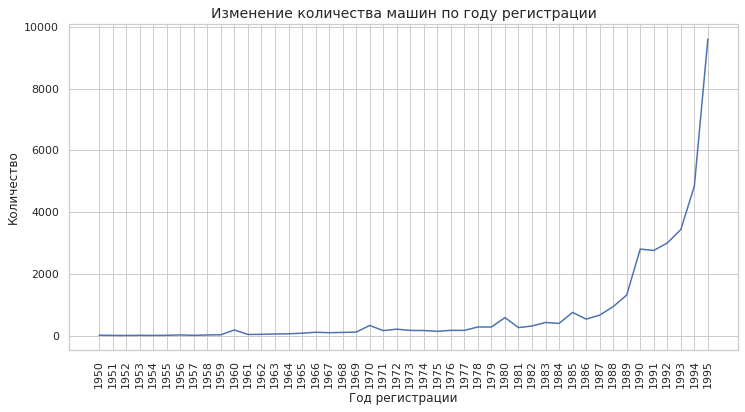

In [34]:
plot_line(df.query('1950 <= registration_year <= 1995'), 'registration_year')
plt.xlabel('Год регистрации')
plt.xticks(rotation=90)
plt.title('Изменение количества машин по году регистрации', size=14);

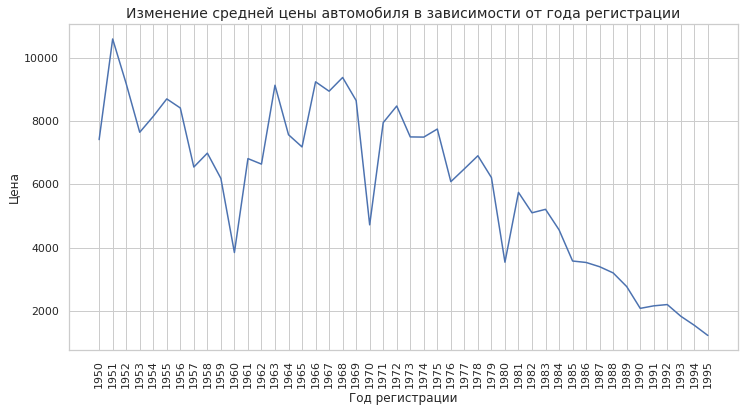

In [35]:
plot_line(df.query('1950 <= registration_year <= 1995'), 'registration_year', count=False)
plt.xlabel('Год регистрации')
plt.xticks(rotation=90)
plt.title('Изменение средней цены автомобиля в зависимости от года регистрации', size=14);

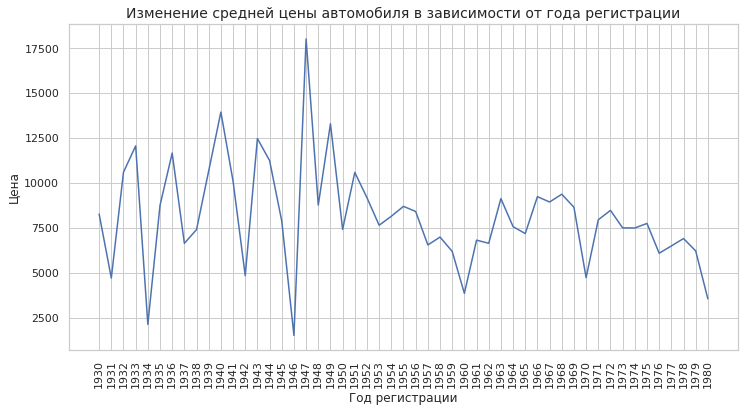

In [36]:
plot_line(df.query('1930 <= registration_year <= 1980'), 'registration_year', count=False)
plt.xlabel('Год регистрации')
plt.xticks(rotation=90)
plt.title('Изменение средней цены автомобиля в зависимости от года регистрации', size=14);

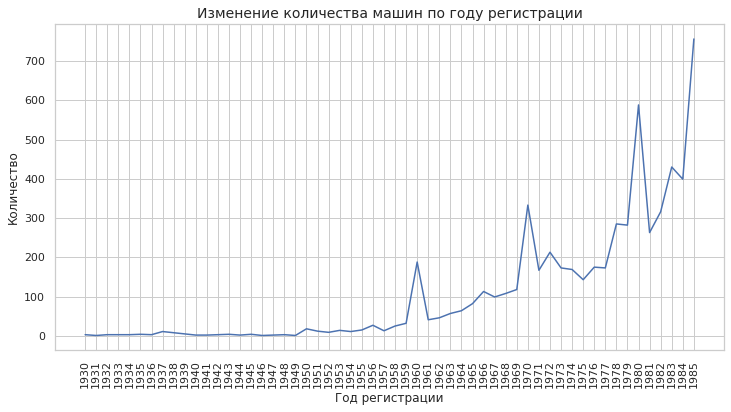

In [37]:
plot_line(df.query('1930 <= registration_year <= 1985'), 'registration_year')
plt.xlabel('Год регистрации')
plt.xticks(rotation=90)
plt.title('Изменение количества машин по году регистрации', size=14);

In [38]:
df.query('registration_year < 1970')['registration_year'].count()

1338

In [39]:
df.query('registration_year == 1970')['registration_year'].count()

333

Модель могла бы в теории предсказывать цену и для раритетного авто, но факторы влияющие на цену таких авто совсем другие, и в числе доступных признаков не представлены. Один из основных факторов - состояние машины. Без этого признака модель даже не сможет отличить ржавую рухлядь от идеально сохранившегося раритета. На графике видны резкие колебания цены, но признаков объясняющих почему средняя цена для машин, например, 46 года ниже 2500 евро, а для машин 47 года выше 17500 евро нет. Учитывая все эти факторы, для повышения точности предсказаний модели, стоит ограничить выборку 1970 годом, так как после идут уже сильные колебания цены, а количество машин сильно снижается. Потеря данных в размере около трети процента обучению модели вряд ли повредит. 

In [40]:
df = df.query('1970 <= registration_year <= 2019')

In [41]:
df.shape[0]

352901

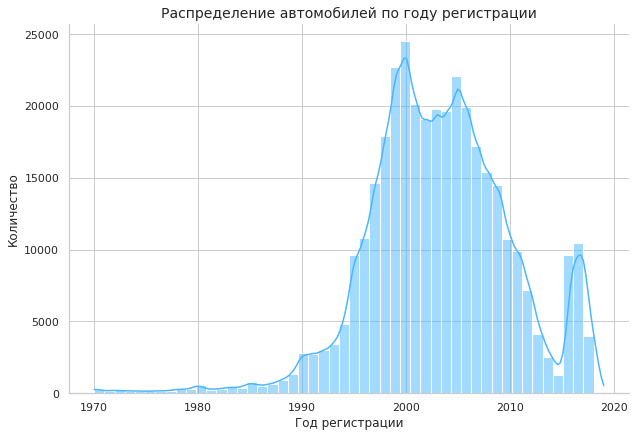

In [42]:
plot_hist(df, 'registration_year', 50)
plt.xlabel('Год регистрации')
plt.title('Распределение автомобилей по году регистрации', size=14);

#### Цена

In [43]:
df['price'].describe()

count    352901.000000
mean       4408.163032
std        4504.536971
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6390.000000
max       20000.000000
Name: price, dtype: float64

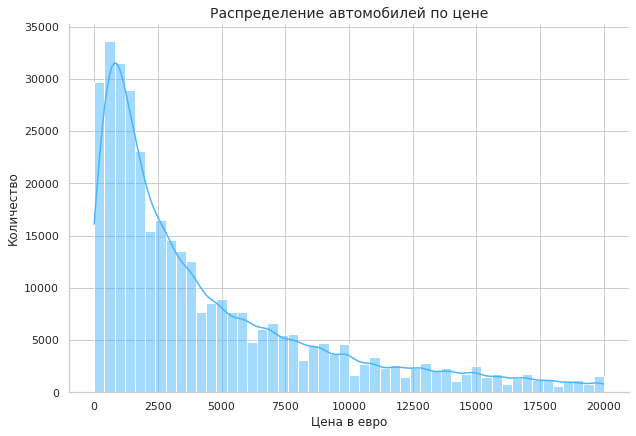

In [44]:
plot_hist(df, 'price', 50)
plt.title('Распределение автомобилей по цене', size=14)
plt.xlabel('Цена в евро');

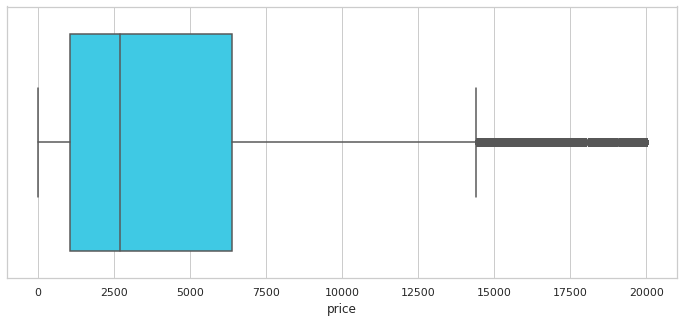

In [45]:
plot_boxplot(df['price'])

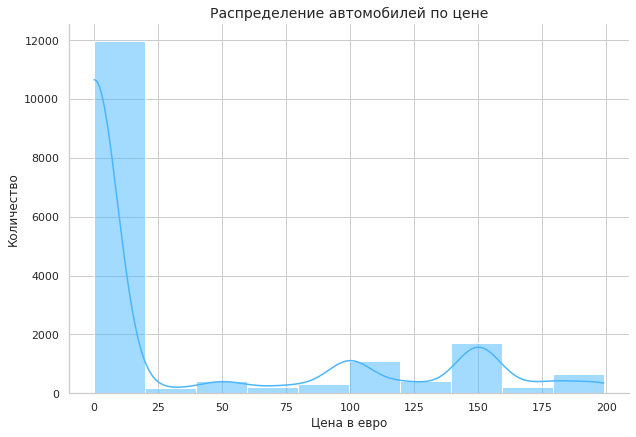

In [46]:
plot_hist(df.query('price < 200'), 'price', 10)
plt.title('Распределение автомобилей по цене', size=14)
plt.xlabel('Цена в евро');

In [47]:
df.query('price == 0').shape[0]

10590

In [48]:
df.query('price == 1').shape[0]

1155

In [49]:
df.query('10 < price <= 200 ').shape[0]

7263

- 10590 машин с ценой 0, 1155 машин с ценой 1 и 5073 с ценой до 200 евро. Опять же, без признака состояние невозможно понять чем обусловлена такая цена и ценность таких данных сомнительна. Точную границу нереалистичной цены провести сложно. Будем отталкиваться от 200 евро.
- Верхняя граница цены выглядит нормально
- Так как цена - это целевой признак, вносить искажения в него нельзя, поэтому остается только отбросить нереалистичные данные

In [50]:
df = df.query('price > 100')

#### Мощность

In [51]:
df['power'].describe()

count    338817.000000
mean        111.675701
std         186.632543
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

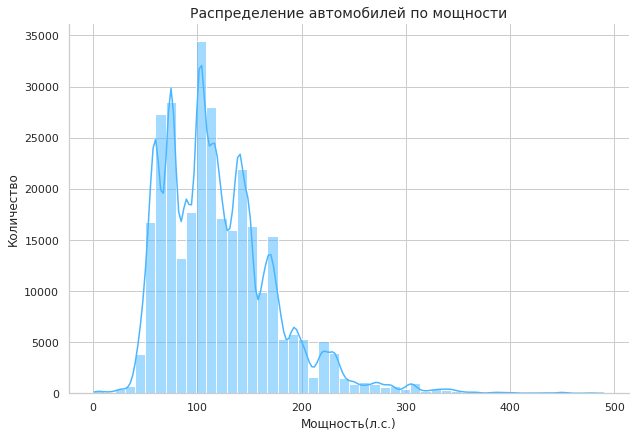

In [52]:
plot_hist(df.query('0 < power < 500'), 'power', 50)
plt.xlabel('Мощность(л.с.)')
plt.title('Распределение автомобилей по мощности', size=14);

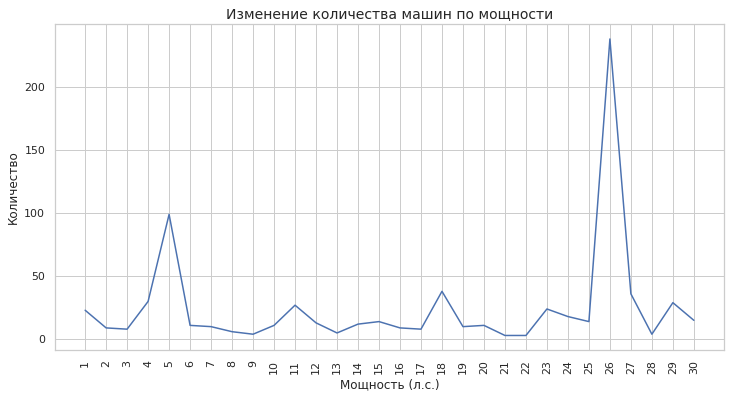

In [53]:
plot_line(df.query('0 < power <= 30'), 'power', count=True)
plt.xlabel('Мощность (л.с.)')
plt.xticks(rotation=90)
plt.title('Изменение количества машин по мощности', size=14);

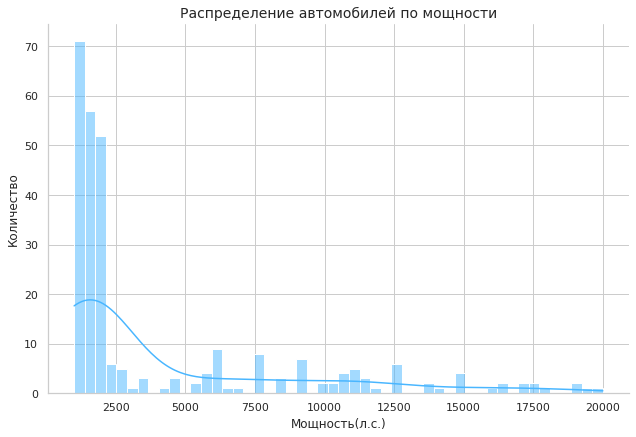

In [54]:
plot_hist(df.query('1000 <= power'), 'power', 50)
plt.xlabel('Мощность(л.с.)')
plt.title('Распределение автомобилей по мощности', size=14);

In [55]:
df.query('power == 0').shape[0]

34215

In [56]:
df.query(' 0 < power <= 12').shape[0]

251

In [57]:
df.query('power >= 500').shape[0]

441

На крупном сайте по продаже машин удалось найти минимальную мощность 12 и максимальную 1200. 
- Машин с мощностью 0 целых 34215,
- Машин,с мощностью между до 12 - 251
- Мощность выше 1200 уж точно результат ошибки ввода, но, ошибка далеко не всегда в одном лишнем знаке. 
- Мощность от 500 до 1200 также встречается как у правдоподобных моделей, так и в виде явных ошибок. 

Попробуем следующую схему:
1. Заменим пропусками значения до 12 и от 1200
2. Сгруппируем по модели и году регистрации и определим медианную мощность для каждой группы
3. Заполним пропуски медианным значением соответствующей группы
4. Для избавления от ошибок в мощности в диапазоне 12 - 1200 мы определим для каждой машины разность между указанной мощностью и медианной и, если она больше установленной границы, мы заменим текущую мощность на медианную

Заменяем пропусками выбросы

In [58]:
df['power'] = np.where(
    ((df['power'] <= 10) | (df['power'] >= 1200)),
    np.nan,
    df['power']
)

Рассчитываем медиану

In [59]:
median_power = df.groupby(['model', 'registration_year'])['power'].transform('median')

In [60]:
df['power'].describe()

count    304159.000000
mean        120.760694
std          55.540297
min          11.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1199.000000
Name: power, dtype: float64

Заменяем пропуски медианным значением

In [61]:
df['power'].fillna(median_power, inplace=True)

Установим границу между медианной мощностью и указанной в 100

In [62]:
threshold = 100

Заменим выбивающиеся значения для каждой группы на медиану

In [63]:
df['power'] = np.where(
    np.abs(median_power - df['power']) > threshold,
    median_power,
    df['power']
)

In [64]:
df['power'].describe()

count    333994.000000
mean        116.655923
std          48.423175
min          11.000000
25%          75.000000
50%         110.000000
75%         143.000000
max        1120.000000
Name: power, dtype: float64

In [65]:
df['power'].isna().sum()

4823

Из почти 35000 пропусков осталось 4823, оставшиеся заполним медианным значением для модели машины, а если пропуски останутся то медианным значением марки

In [66]:
median_power = df.groupby(['model'])['power'].transform('median')
df['power'].fillna(median_power, inplace=True)

In [67]:
df['power'].isna().sum()

4597

In [68]:
median_power = df.groupby(['brand'])['power'].transform('median')
df['power'].fillna(median_power, inplace=True)

In [69]:
df['power'].isna().sum()

0

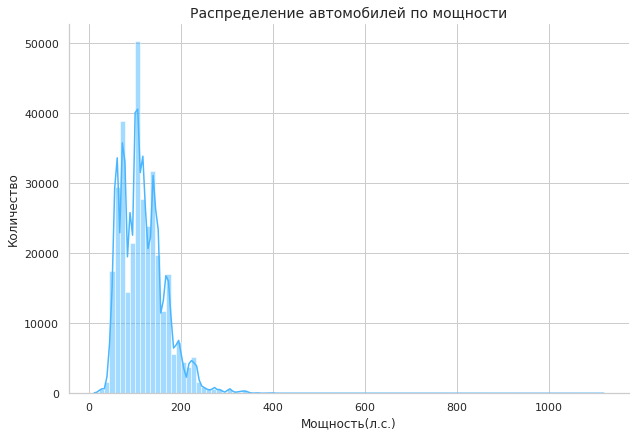

In [70]:
plot_hist(df, 'power', 100)
plt.xlabel('Мощность(л.с.)')
plt.title('Распределение автомобилей по мощности', size=14);

Мы заменили аномальные значения медианнымы значениями для групп модель + год регистрации/модель/марка

Вернем столбцу `power` целочесленный тип данных

In [71]:
df['power'] = df['power'].astype('int64')

#### Пробег

In [72]:
df['kilometer'].describe()

count    338817.000000
mean     128702.337840
std       36989.088095
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

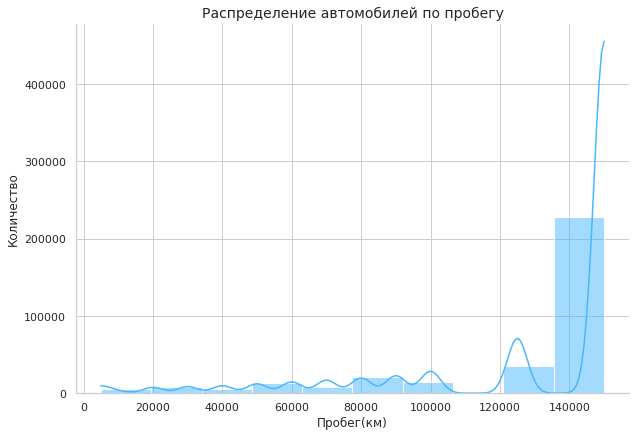

In [73]:
plot_hist(df, 'kilometer', 10)
plt.xlabel('Пробег(км)')
plt.title('Распределение автомобилей по пробегу', size=14);

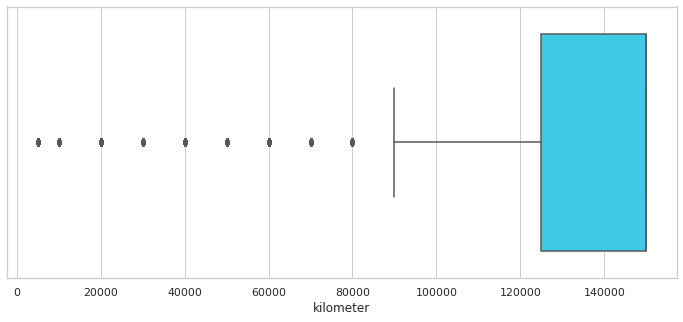

In [74]:
plot_boxplot(df['kilometer'])

Выбросов в признаке пробег не наблюдается, половина всех машин имеет пробег близкий к максимальному - 150000 км 

#### Категориальные признаки

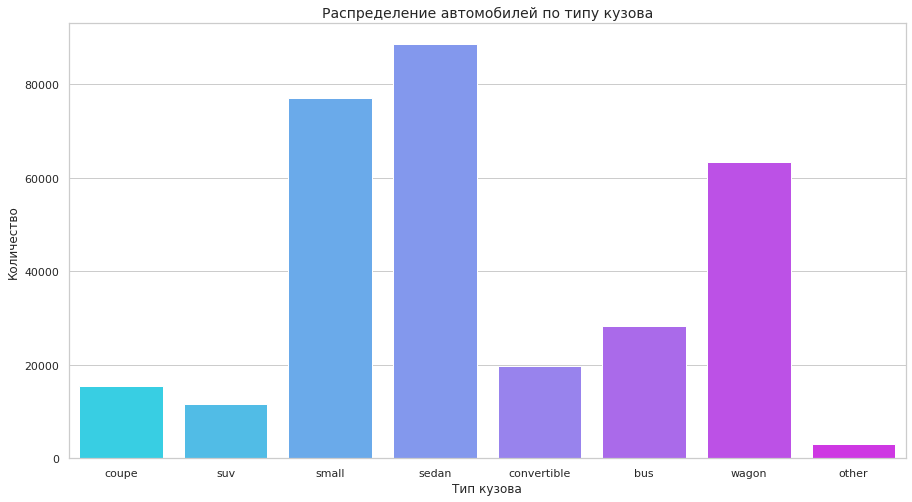

In [75]:
plot_bar(df, 'vehicle_type', orientation='vertical')
plt.xlabel('Тип кузова')
plt.title('Распределение автомобилей по типу кузова', size=14);

In [76]:
pd.crosstab(df['vehicle_type'], df['model'])

model,100,145,147,156,159,1_reihe,1er,200,2_reihe,300c,...,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
vehicle_type,,,,,,,,,,,,,,,,,,,,,
bus,0,0,0,0,0,5,0,0,3,0,...,0,3,1,0,0,42,0,0,0,2364
convertible,1,0,0,0,0,6,251,1,1497,0,...,0,0,0,0,0,0,0,1,646,1
coupe,2,2,26,3,0,3,243,0,33,0,...,0,0,0,0,0,0,0,0,50,1
other,0,1,6,1,0,1,20,0,10,0,...,1,1,1,0,0,3,2,0,0,22
sedan,263,12,358,265,55,30,2642,15,186,59,...,0,725,0,121,3,27,0,0,1,22
small,0,19,93,2,0,1042,138,0,2473,0,...,0,0,0,0,0,879,0,173,0,11
suv,0,0,0,0,0,0,0,0,4,0,...,92,770,195,0,216,0,168,0,0,7
wagon,103,0,2,281,143,53,20,1,270,69,...,0,8,0,30,41,7,1,0,0,223


In [77]:
df['vehicle_type'].isna().sum()

32048

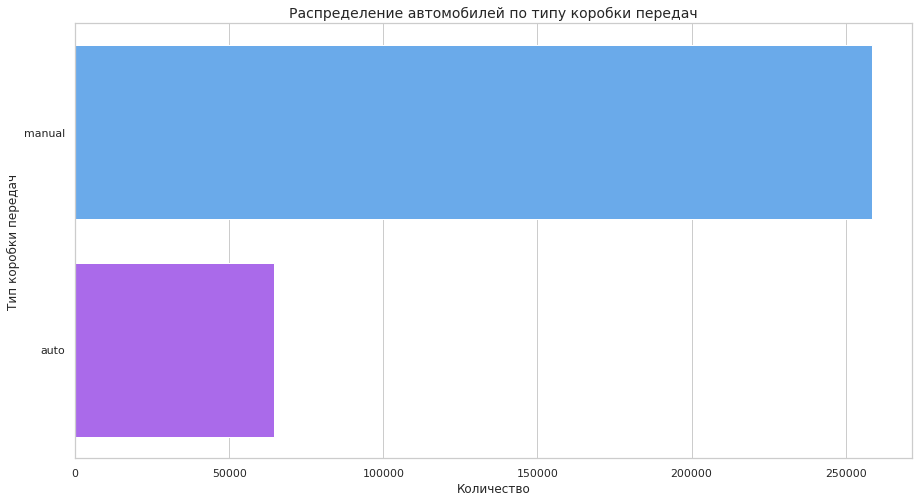

In [78]:
plot_bar(df, 'gearbox', orientation='horizontal')
plt.ylabel('Тип коробки передач')
plt.title('Распределение автомобилей по типу коробки передач', size=14);

In [79]:
pd.crosstab(df['gearbox'], df['model'])

model,100,145,147,156,159,1_reihe,1er,200,2_reihe,300c,...,wrangler,x_reihe,x_trail,x_type,xc_reihe,yaris,yeti,ypsilon,z_reihe,zafira
gearbox,,,,,,,,,,,,,,,,,,,,,
auto,59,0,26,41,26,71,420,4,149,134,...,7,943,18,77,191,91,31,14,76,304
manual,318,37,515,531,181,1116,3009,12,4460,1,...,84,571,181,82,68,908,142,175,618,2521


In [80]:
df['gearbox'].isna().sum()

15786

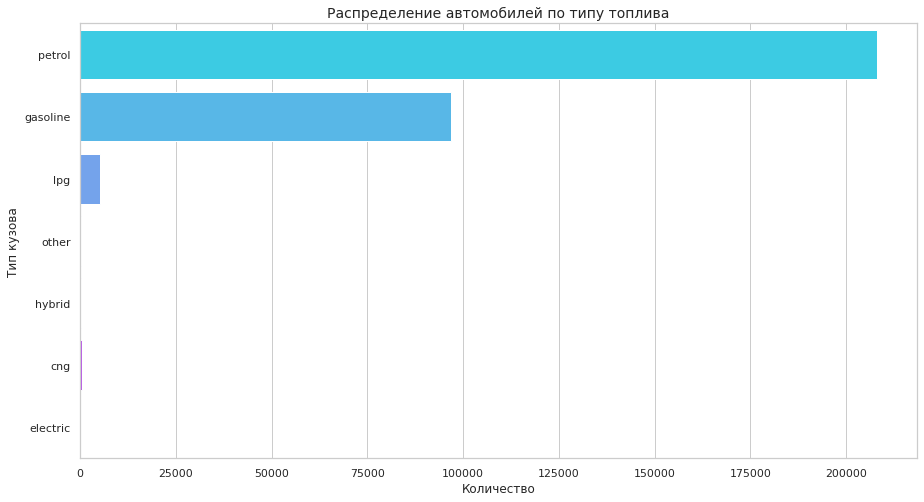

In [81]:
plot_bar(df, 'fuel_type', orientation='horizontal')
plt.ylabel('Тип кузова')
plt.title('Распределение автомобилей по типу топлива', size=14);

In [82]:
df['fuel_type'].isna().sum()

27729

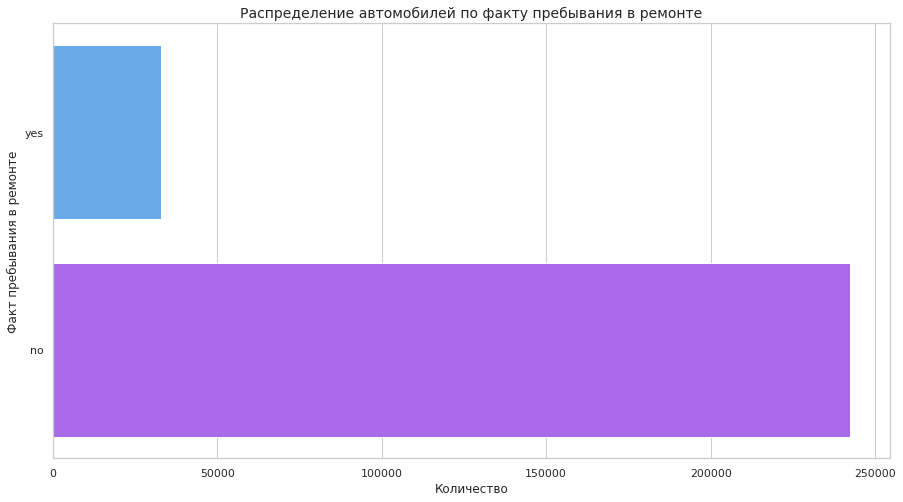

In [83]:
plot_bar(df, 'repaired', orientation='horizontal')
plt.ylabel('Факт пребывания в ремонте')
plt.title('Распределение автомобилей по факту пребывания в ремонте', size=14);

In [84]:
df['repaired'].isna().sum()

63456

Можно было бы заполнить пропуски в типах кузова, коробке передач и топлива модой для каждой группы модель + год выпуска, но из-за того, что для одной модели могут встречаться разные варианты вышеперечисленных признаков, этот метод может внести искажения в данные, поэтому заполним пропуски заглушкой `unknown` в том числе и пропуски в названиях модели

In [85]:
categorical_features = list(filter(lambda x: df[x].dtype == 'object', df.columns))

In [86]:
df[categorical_features] = df[categorical_features].fillna('unknown')

In [87]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [88]:
df['model'].nunique()

251

Поменяем значение `other` у моделей на `unknown`

In [89]:
df['model'] = np.where(
    df['model'] == 'other',
    'unknown',
    df['model']
)               

In [90]:
models = df.groupby('model')['brand'].nunique().sort_values(ascending=False).head(15)

In [91]:
models

model
unknown       40
grand          3
3_reihe        2
freelander     2
discovery      2
1_reihe        2
matiz          2
defender       2
5_reihe        2
passat         1
panda          1
100            1
pajero         1
picanto        1
outlander      1
Name: brand, dtype: int64

За исключением 8 моделей + заглушки `unknown`, остальные 240 моделей соответствуют каждая своей марке, а значит наличие и марки и модели автомобиля в признаках избыточна. Отбросим столбец с марками, модели соответствующие одной марке оставим как есть, а для соответствующих нескольким маркам дополним название модели, например `opel_unknown`

Выберем названия моделей которые соответствую более чем одной марке машины

In [92]:
models = models[models > 1].index.tolist()

In [93]:
models

['unknown',
 'grand',
 '3_reihe',
 'freelander',
 'discovery',
 '1_reihe',
 'matiz',
 'defender',
 '5_reihe']

Дополним название модели маркой для моделей из списка

In [94]:
df.loc[df['model'].isin(models), 'model'] = df['brand'] + '_' + df['model']

In [95]:
df.groupby('model')['brand'].nunique().sort_values(ascending=False).head(5)

model
100                1
porsche_unknown    1
picanto            1
phaeton            1
peugeot_unknown    1
Name: brand, dtype: int64

Теперь каждая модель соответствует только одной марке и признак `brand` нам больше не нужен

In [96]:
df.drop('brand', axis=1, inplace=True)

---

### Промежуточный вывод

- Мы привели название столбцов к корректному формату
- Проверили на наличие корреляции между числовыми признаками
- Скорректировали диапазон года регистрации представленных машин отталкиваясь от недостатка признаков для прогнозирования цены раритеного авто
- Избавились от выбросов в целевом признаке, ограничив выборку "снизу" ценой в 200 евро
- Для признака мощность:
    - Заменили пропусками нереалистичные значения до 12 и от 1200
    - Сгруппировали по модели и году регистрации и определили медианную мощность для каждой группы
    - Заполнили пропуски медианным значением соответствующей группы
    - Для избавления от ошибок в мощности внутри диапазона 12-1200, мы задали границу разности равной 100 и заменили указанное значение мощности в тех случаях, когда разность между указанной мощностью и медианной была больше границы.
- Распределение автомобилей по пробегу выглядит реалистично
- Для категориальных признаков:
    - Мы заполнили пропуски заглушкой `unknown`
    - Также заменили текущую заглушку в признаке модель `other` на `unknown`
    - Изучили принадлежность моделей к одной марке, выбрали модели которые соответствуют более чем одной марке и дополнили их название указанием на марку.
    - Отбросили признак марка, ставший излишним
    
**Данные подготовлены, можем переходить к разделению на выборки**

### Подготовим выборки

#### Отделим целевой признак

In [97]:
df = shuffle(df, random_state=1)

In [98]:
X = df.drop('price', axis=1)
y = df['price']

#### Разделим на выборки

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [100]:
get_size(get_dict())

- Размер выборки features_train: (244794, 8)
- Размер выборки features_test: (50823, 8)
- Размер выборки features_valid: (43200, 8)
- Размер выборки target_train: (244794,)
- Размер выборки target_valid: (43200,)
- Размер выборки target_test: (50823,)


#### Кодирование и масштабирование признаков

Для кодирования такого числа признаков с большим количеством уникальных значений воспользуемся методом `TargetEncoder`, категориальные признаки заполним средним значением целевого признака по данному значению признака

In [101]:
encoder = TargetEncoder() 

Несмотря на то, что на модели градиентного бустинга и решающих деревьев масштабирование признаков не оказывает существенного влияния, масштабирование признаков разного масштаба им не повредит и может пригодиться при тестировании других моделей

In [102]:
scaler = StandardScaler()

Объединим в пайплайн
- Кодирование категориальных признаков
- Последующее масштабирование всех признаков, в том числе и закодированных категориальных
- Обучение модели, пока что на этом месте оставим заглушку

In [103]:
final_pipe = Pipeline(steps=[('encoder', encoder),
                             ('scaler', scaler),
                             ('model', None)])

Проверим работу препроцессора

In [104]:
X_train_processed = final_pipe.fit_transform(X_train, y_train)

In [105]:
feature_names = final_pipe.get_feature_names_out()

In [106]:
pd.DataFrame(X_train_processed, columns=feature_names).head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,0.159724,-1.215941,-0.404313,-0.553644,-0.102977,0.574572,1.528768,0.620500
1,0.159724,0.530826,-0.404313,-0.449907,1.073328,-1.049564,-1.335092,-1.348393
2,1.030139,-0.924813,-0.404313,0.296999,-0.756583,0.574572,-0.532560,0.620500
3,0.159724,-1.070377,-0.404313,-0.864855,-0.795677,-2.132322,-0.532560,0.620500
4,0.159724,-0.779249,-0.404313,0.691200,0.246388,0.574572,-0.532560,0.620500


In [107]:
del df, X, y

### Промежуточный вывод

Мы подготовили выборки
 - Перемешав и отделив целевой признак
 - Разделили на обучающую, валидационную и тестовую выборки в соотношении 70:15:15
 - Создали пайплайн, включающий в себя:
    - Кодирование категориальных признаков методом `TargetEncoder`
    - Масштабирование всех признаков методом `StandardScaler`
    - Обучение модели 

## Обучение моделей

Мы протестируем следующие модели машинного обучения:

- KNN-Regressor
- ElasticNet
- CatBoost
- LightGBM


Для каждой модели подберем оптимальные гиперпараметры с помощью фреймворка optuna

### KNN-Regressor

In [108]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [109]:
n_trial = 10

In [110]:
def objective_knn(trial):
    
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),  
    }
    
    model = KNeighborsRegressor(**params)
    final_pipe.steps[2] = ('model', model)
    final_pipe.fit(X_train, y_train)
    predictions = final_pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [111]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_knn, n_trials=n_trial, show_progress_bar=False)

[I 2023-11-12 14:58:34,678] A new study created in memory with name: no-name-cacb6e25-e6f5-463b-9c39-6ca335b6fdaf
[I 2023-11-12 14:58:47,938] Trial 0 finished with value: 1884.401403910908 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 1884.401403910908.
[I 2023-11-12 14:58:54,746] Trial 1 finished with value: 2236.4077609507485 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 1884.401403910908.
[I 2023-11-12 14:59:05,723] Trial 2 finished with value: 1898.2400093776762 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 1884.401403910908.
[I 2023-11-12 14:59:16,325] Trial 3 finished with value: 1863.2596688546937 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 1863.2596688546937.
[I 2023-11-12 14:59:29,457] Trial 4 finished with value: 1831.119550856645 and parameters: {'n_neighbors': 8, 'weights': 'unifor

In [112]:
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее RMSE:', study.best_value)

Лучшие гиперпараметры: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}
Лучшее RMSE: 1787.638882373955


In [113]:
knn_params = study.best_params

### ElasticNet

In [114]:
67618, 'l1_ratio': 0.2667523758534821}. Best is trial 4 with value: 2855.4139429426787.def objective_elastic_net(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-5, 1e2, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1.0),
    }
    
    model = ElasticNet(**params)
    final_pipe.steps[2] = ('model', model)
    final_pipe.fit(X_train, y_train)
    predictions = final_pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [115]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_elastic_net, n_trials=n_trial, show_progress_bar=False)

[I 2023-11-12 15:00:32,697] A new study created in memory with name: no-name-199a867f-ac12-48e8-9f6b-e0d759827e49
[I 2023-11-12 15:00:35,543] Trial 0 finished with value: 2855.4659010222445 and parameters: {'alpha': 0.002166528726950065, 'l1_ratio': 0.23599333167489775}. Best is trial 0 with value: 2855.4659010222445.
[I 2023-11-12 15:00:37,345] Trial 1 finished with value: 3066.92559358446 and parameters: {'alpha': 2.9836196191866895, 'l1_ratio': 0.7312111317854658}. Best is trial 0 with value: 2855.4659010222445.
[I 2023-11-12 15:00:40,198] Trial 2 finished with value: 2856.8225976823032 and parameters: {'alpha': 0.029765693535318518, 'l1_ratio': 0.05524917034468805}. Best is trial 0 with value: 2855.4659010222445.
[I 2023-11-12 15:00:42,685] Trial 3 finished with value: 2855.6791616578785 and parameters: {'alpha': 0.011050631020476468, 'l1_ratio': 0.32660858782271934}. Best is trial 0 with value: 2855.4659010222445.
[I 2023-11-12 15:00:45,495] Trial 4 finished with value: 2855.41394

In [116]:
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее RMSE:', study.best_value)

Лучшие гиперпараметры: {'alpha': 1.1350216279962552e-05, 'l1_ratio': 0.8754763085594398}
Лучшее RMSE: 2855.4139429426787


In [117]:
elastic_net_params = study.best_params

### CatBoost

In [118]:
def objective_cb(trial):
      
    params = {
        'iterations': 500,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 1, 16),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }
        
    model = cb.CatBoostRegressor(**params, silent=True) 
    final_pipe.steps[2] = ('model', model)
    final_pipe.fit(X_train, y_train)
    predictions = final_pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [119]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_cb, n_trials=n_trial, show_progress_bar=False)

[I 2023-11-12 15:00:57,295] A new study created in memory with name: no-name-71de820a-0394-4c6d-9b2c-97c5f04f8978
[I 2023-11-12 15:01:08,320] Trial 0 finished with value: 1913.1357193475353 and parameters: {'learning_rate': 0.07872850372741624, 'depth': 5, 'subsample': 0.18562727845391191, 'colsample_bylevel': 0.21364154860619805, 'min_data_in_leaf': 15}. Best is trial 0 with value: 1913.1357193475353.
[I 2023-11-12 15:01:30,090] Trial 1 finished with value: 2970.281537042334 and parameters: {'learning_rate': 0.002102825021260185, 'depth': 14, 'subsample': 0.38273295515241096, 'colsample_bylevel': 0.2532814106398478, 'min_data_in_leaf': 34}. Best is trial 0 with value: 1913.1357193475353.
[I 2023-11-12 15:01:41,240] Trial 2 finished with value: 2728.637883682475 and parameters: {'learning_rate': 0.012127594017731053, 'depth': 1, 'subsample': 0.303391884431732, 'colsample_bylevel': 0.7943178495019672, 'min_data_in_leaf': 66}. Best is trial 0 with value: 1913.1357193475353.
[I 2023-11-12

In [120]:
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее RMSE:', study.best_value)

Лучшие гиперпараметры: {'learning_rate': 0.06897932020214306, 'depth': 11, 'subsample': 0.6153553983805347, 'colsample_bylevel': 0.4455767795796125, 'min_data_in_leaf': 48}
Лучшее RMSE: 1698.6528822158455


In [121]:
cb_params = study.best_params

### LightGBM

In [124]:
def objective_lightgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.1, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    }
    
    model = lgb.LGBMRegressor(**params, verbose=1)
    final_pipe.steps[2] = ('model', model)
    final_pipe.fit(X_train, y_train)
    predictions = final_pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [125]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_lightgbm, n_trials=n_trial, show_progress_bar=False)

[I 2023-11-12 15:06:18,432] A new study created in memory with name: no-name-4098c477-6173-4e05-8f69-ad54889f67f4
[I 2023-11-12 15:18:05,345] Trial 0 finished with value: 1866.555527260445 and parameters: {'num_leaves': 44, 'learning_rate': 0.04531909674204613, 'min_child_samples': 22, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 1866.555527260445.
[I 2023-11-12 15:24:07,653] Trial 1 finished with value: 3646.5655465447708 and parameters: {'num_leaves': 27, 'learning_rate': 0.013615300350346313, 'min_child_samples': 49, 'boosting_type': 'dart'}. Best is trial 0 with value: 1866.555527260445.
[I 2023-11-12 15:25:36,140] Trial 2 finished with value: 2290.65812513218 and parameters: {'num_leaves': 7, 'learning_rate': 0.025693992674257517, 'min_child_samples': 28, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 1866.555527260445.
[I 2023-11-12 15:37:38,270] Trial 3 finished with value: 1786.9738059311856 and parameters: {'num_leaves': 58, 'learning_rate': 0.06740191518115758

In [126]:
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее RMSE:', study.best_value)

Лучшие гиперпараметры: {'num_leaves': 58, 'learning_rate': 0.06740191518115758, 'min_child_samples': 34, 'boosting_type': 'gbdt'}
Лучшее RMSE: 1786.9738059311856


In [127]:
lgbm_params = study.best_params

## Анализ моделей

Для каждой модели мы подобрали оптимальные гиперпараметры, теперь необходимо сравнить их по трем критериям, установленным заказчиком

- Качество предсказания
- Время обучения модели
- Время предсказания модели

In [128]:
def test_model(model, params, X_test, y_test, *, with_timing=True):

    model.set_params(**params)
    final_pipe.steps[2] = ('model', model)
    
    start_time = time.time()
    final_pipe.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = final_pipe.predict(X_test)
    pred_time = time.time() - start_time
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if with_timing == True:
        return rmse, fit_time, pred_time
    else:
        return rmse

In [129]:
results_table = pd.DataFrame(index=['RMSE', 'fit_time', 'pred_time'])

In [130]:
results_table['KNN'] = test_model(KNeighborsRegressor(), knn_params, X_val, y_val)

In [131]:
results_table['ElasticNet'] = test_model(ElasticNet(), elastic_net_params, X_val, y_val)

In [132]:
results_table['CatBoost'] = test_model(cb.CatBoostRegressor(silent=True), cb_params, X_val, y_val)

In [133]:
results_table['LightGBM'] = test_model(lgb.LGBMRegressor(), lgbm_params, X_val, y_val)

P.S. Пробовал разные варианты цикла для заполнения таблицы, но на каждом варианте ядро почему-то умирало и приходилось запускать весь код заново

In [134]:
results_table

,KNN,ElasticNet,CatBoost,LightGBM
RMSE,1787.638882,2855.413943,1655.791204,1786.973806
fit_time,1.672727,2.469381,47.794145,745.198091
pred_time,10.791022,0.286068,0.334436,0.606840


In [159]:
scaler = StandardScaler()

In [160]:
normalized_results = scaler.fit_transform(results_table)

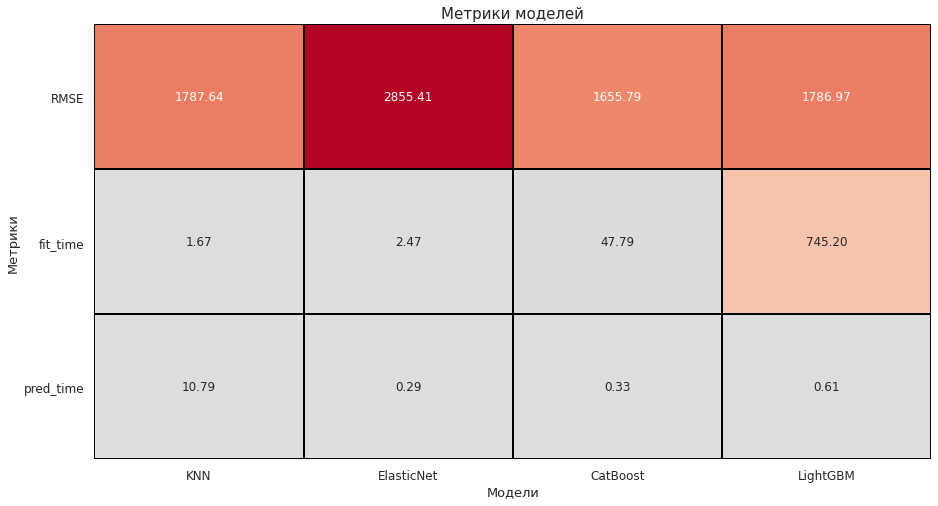

In [191]:
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(results_table, cmap='coolwarm',
                      cbar_kws={'label': 'Normalized Values'},
                      linewidths=1, linecolor='black', yticklabels=results_table.index,
                      xticklabels=results_table.columns, annot=True, fmt='.2f', cbar=False, center=10, vmin=0)
plt.title('Метрики моделей', size=15)
plt.xlabel('Модели', size=13)
plt.ylabel('Метрики', size=13)
plt.xticks(size=12)
plt.yticks(size=12, rotation=0);

- KNN и CatBoost, очевидно, обошли две другие модели по совокупности метрик
- KNN значительно превосходит CatBoost по скорости обучения - 1.67 против 47.79, однако, незначительно уступает CatBoost по RMSE и значительно проигрывает по скорости предсказания.

**Заказчик не уточнял, равнозначны ли метрики, но можно предположить, что для приложения, которое должно предсказывать цену в реальном времени, скорость предсказания играет весомую роль. Помимо этого, CatBoost все-таки показывает себя лучше и имеет большой потенциал в дальнейшей оптимизации гиперпараметров путем расширения сетки гиперпараметров и увеличения количества итераций подбора. По 2 из 3 метрик CatBoost опередил KNN-Regressor и его мы и изберем для финального тестирования**

## Финальное тестирование

Проверим на тестовой выборке модель CatBoost и константную и сравним их результаты с целью проверки адекватности нашей модели

In [192]:
cb_rmse = test_model(cb.CatBoostRegressor(silent=True), cb_params, X_test, y_test, with_timing=False)

In [193]:
dummy_params = {'strategy' : 'median'}

In [194]:
dummy_rmse = test_model(DummyRegressor(), dummy_params, X_test, y_test, with_timing=False)

In [195]:
print(f'Результаты на тестовой выборке для:\nCatBoost: {cb_rmse}\nDummyRegressor: {dummy_rmse}')

Результаты на тестовой выборке для:
CatBoost: 1663.350865285016
DummyRegressor: 4814.164237715134


Наша модель превзошшла константную почти в три раза, неплохой результат

## Вывод

В рамках проекта по созданию модели, способной предсказывать рыночную стоимость автомобиля мы провели тщательную подготовку данных, внесли коррективы в структуру и формат признаков, обработали выбросы и пропуски. Затем мы рассмотрели несколько моделей, сравнили их по критериям, установленным заказчиком - RMSE, времени обучения и времени предсказания.

|     | KNN | ElasticNet | CatBoost | LightGBM |
| --- | --- | --- | --- | --- |
| RMSE | 1787.638882 | 2855.413943 | 1655.791204 | 1786.973806 |
| fit_time | 1.672727 | 2.469381 | 47.794145 | 745.198091 |
| pred_time | 10.791022 | 0.286068 | 0.334436 | 0.606840 |

Из результатов сравнения моделей видно, что CatBoost показал себя лучше всего с точки зрения качества предсказания и имеет потенциал для дальнейшей оптимизации. Важным фактором является также скорость предсказания, особенно для приложения, ориентированного на реальное время. CatBoost показал достойные результаты и стал выбором для финального тестирования.

На тестовой выборке CatBoost продемонстрировал RMSE 1663.35, что почти в три раза превосходит результат DummyRegressor (RMSE 4814.16). Это подтверждает эффективность выбранной модели для поставленной задачи.
